# Stroke prediction using MLlib

In [223]:
!pip install pca

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9680 sha256=9d7ee0ed8f1c12aeacb460e4bf102a526a6245110030aec5b03f4c6d8380765d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### Importing Packages

In [318]:
from pyspark.sql import SparkSession
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

import pca

pd.options.mode.chained_assignment = None

In [192]:
# To increase size of plots
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 5]

### Reading dataset

In [193]:
data = pd.read_csv("gs://cc-project-bucket-spark/healthcare-dataset-stroke-data.csv")
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [302]:
feature_cols = ["gender", "age", "hypertension", 
                "heart_disease", "ever_married", "work_type", 
                "Residence_type", "avg_glucose_level", "bmi", 
                "smoking_status"]

### Cleaning dataset

In [194]:
data = data.drop(columns = ["id"])

# gender
data.gender[data.gender == "Male"] = 0
data.gender[data.gender == "Female"] = 1
data.gender[data.gender == "Other"] = 2

# ever_married
data.ever_married[data.ever_married == "Yes"] = 1
data.ever_married[data.ever_married == "No"] = 0

# work_type
data.work_type[data.work_type == "Private"] = 0
data.work_type[data.work_type == "Self-employed"] = 1
data.work_type[data.work_type == "children"] = 2
data.work_type[data.work_type == "Govt_job"] = 3
data.work_type[data.work_type == "Never_worked"] = 4

# Residence_type
data.Residence_type[data.Residence_type == "Urban"] = 0
data.Residence_type[data.Residence_type == "Rural"] = 1

# smoking_status
data.smoking_status[data.smoking_status == "never smoked"] = 0
data.smoking_status[data.smoking_status == "Unknown"] = 1
data.smoking_status[data.smoking_status == "formerly smoked"] = 2
data.smoking_status[data.smoking_status == "smokes"] = 3

# Dropping NaN values
print(f"Before NaN Drop: ROW:{data.shape[0]}, COL:{data.shape[1]}")
data = data.dropna()
print(f"After NaN Drop: ROW:{data.shape[0]}, COL:{data.shape[1]}")

Before NaN Drop: ROW:5110, COL:11
After NaN Drop: ROW:4909, COL:11


In [195]:
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,0,228.69,36.6,2,1
2,0,80.0,0,1,1,0,1,105.92,32.5,0,1
3,1,49.0,0,0,1,0,0,171.23,34.4,3,1
4,1,79.0,1,0,1,1,1,174.12,24.0,0,1
5,0,81.0,0,0,1,0,0,186.21,29.0,2,1


### Shuffling dataset

In [196]:
data = data.sample(frac = 1).reset_index(drop = True)
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,14.0,0,0,0,2,1,91.25,23.8,1,0
1,0,48.0,0,0,0,1,1,64.18,32.1,0,0
2,1,53.0,0,0,1,0,1,83.91,36.6,1,0
3,0,28.0,0,0,0,0,0,74.61,32.7,1,0
4,1,33.0,0,0,1,0,1,71.16,46.5,3,0


### Visualizing data

Text(0.5, 1.0, 'Stroke counts')

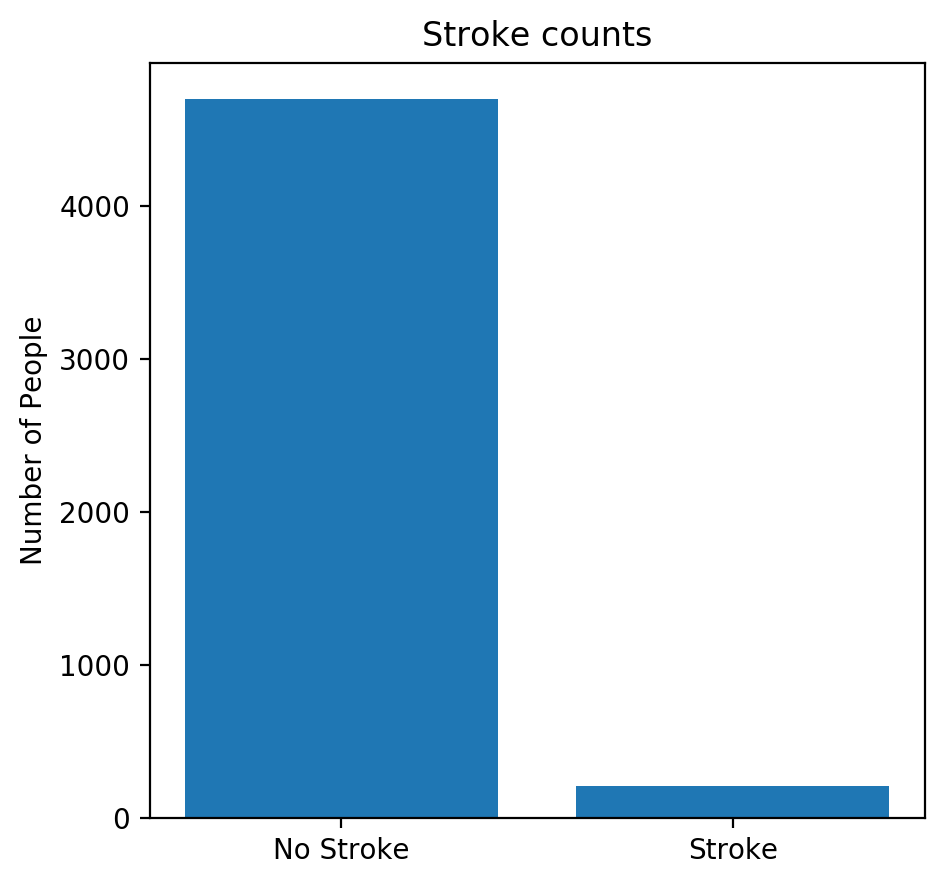

In [197]:
plt.bar(x = ["No Stroke", "Stroke"], height = [data["stroke"].value_counts()[0], data["stroke"].value_counts()[1]])
plt.ylabel("Number of People")b
plt.title("Stroke counts")

In [220]:
print(data["stroke"].value_counts())

0    4700
1     209
Name: stroke, dtype: int64


**Describing People who had Strokes**

In [221]:
data[data["stroke"] == 1][["age", "avg_glucose_level", "bmi"]].describe()

,age,avg_glucose_level,bmi
count,209.000000,209.000000,209.000000
mean,67.712919,134.571388,30.471292
std,12.402848,62.462047,6.329452
min,14.000000,56.110000,16.900000
25%,58.000000,80.430000,26.400000
50%,70.000000,106.580000,29.700000
75%,78.000000,196.920000,33.700000
max,82.000000,271.740000,56.600000


**Describing People who did not have Strokes**

In [222]:
data[data["stroke"] == 0][["age", "avg_glucose_level", "bmi"]].describe()

,age,avg_glucose_level,bmi
count,4700.000000,4700.000000,4700.000000
mean,41.760451,104.003736,28.823064
std,22.268129,42.997798,7.908287
min,0.080000,55.120000,10.300000
25%,24.000000,76.887500,23.400000
50%,43.000000,91.210000,28.000000
75%,59.000000,112.432500,33.100000
max,82.000000,267.760000,97.600000


**Feature Importance using PCA**

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [11] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [2] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [11] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
     PC            feature   loading  type
0   PC1  avg_glucose_level  0.987035  best
1   PC2                age -0.980195  best
2   PC2             gender -0.001089  weak
3   PC2       hypertension -0.002990  weak
4   PC2      heart_disease -0.002103  weak
5   PC2       ever_married -0.014261  weak
6   PC2          work_type  0.009426  weak
7   PC2     Residence_type  0.000310  weak
8   PC2       

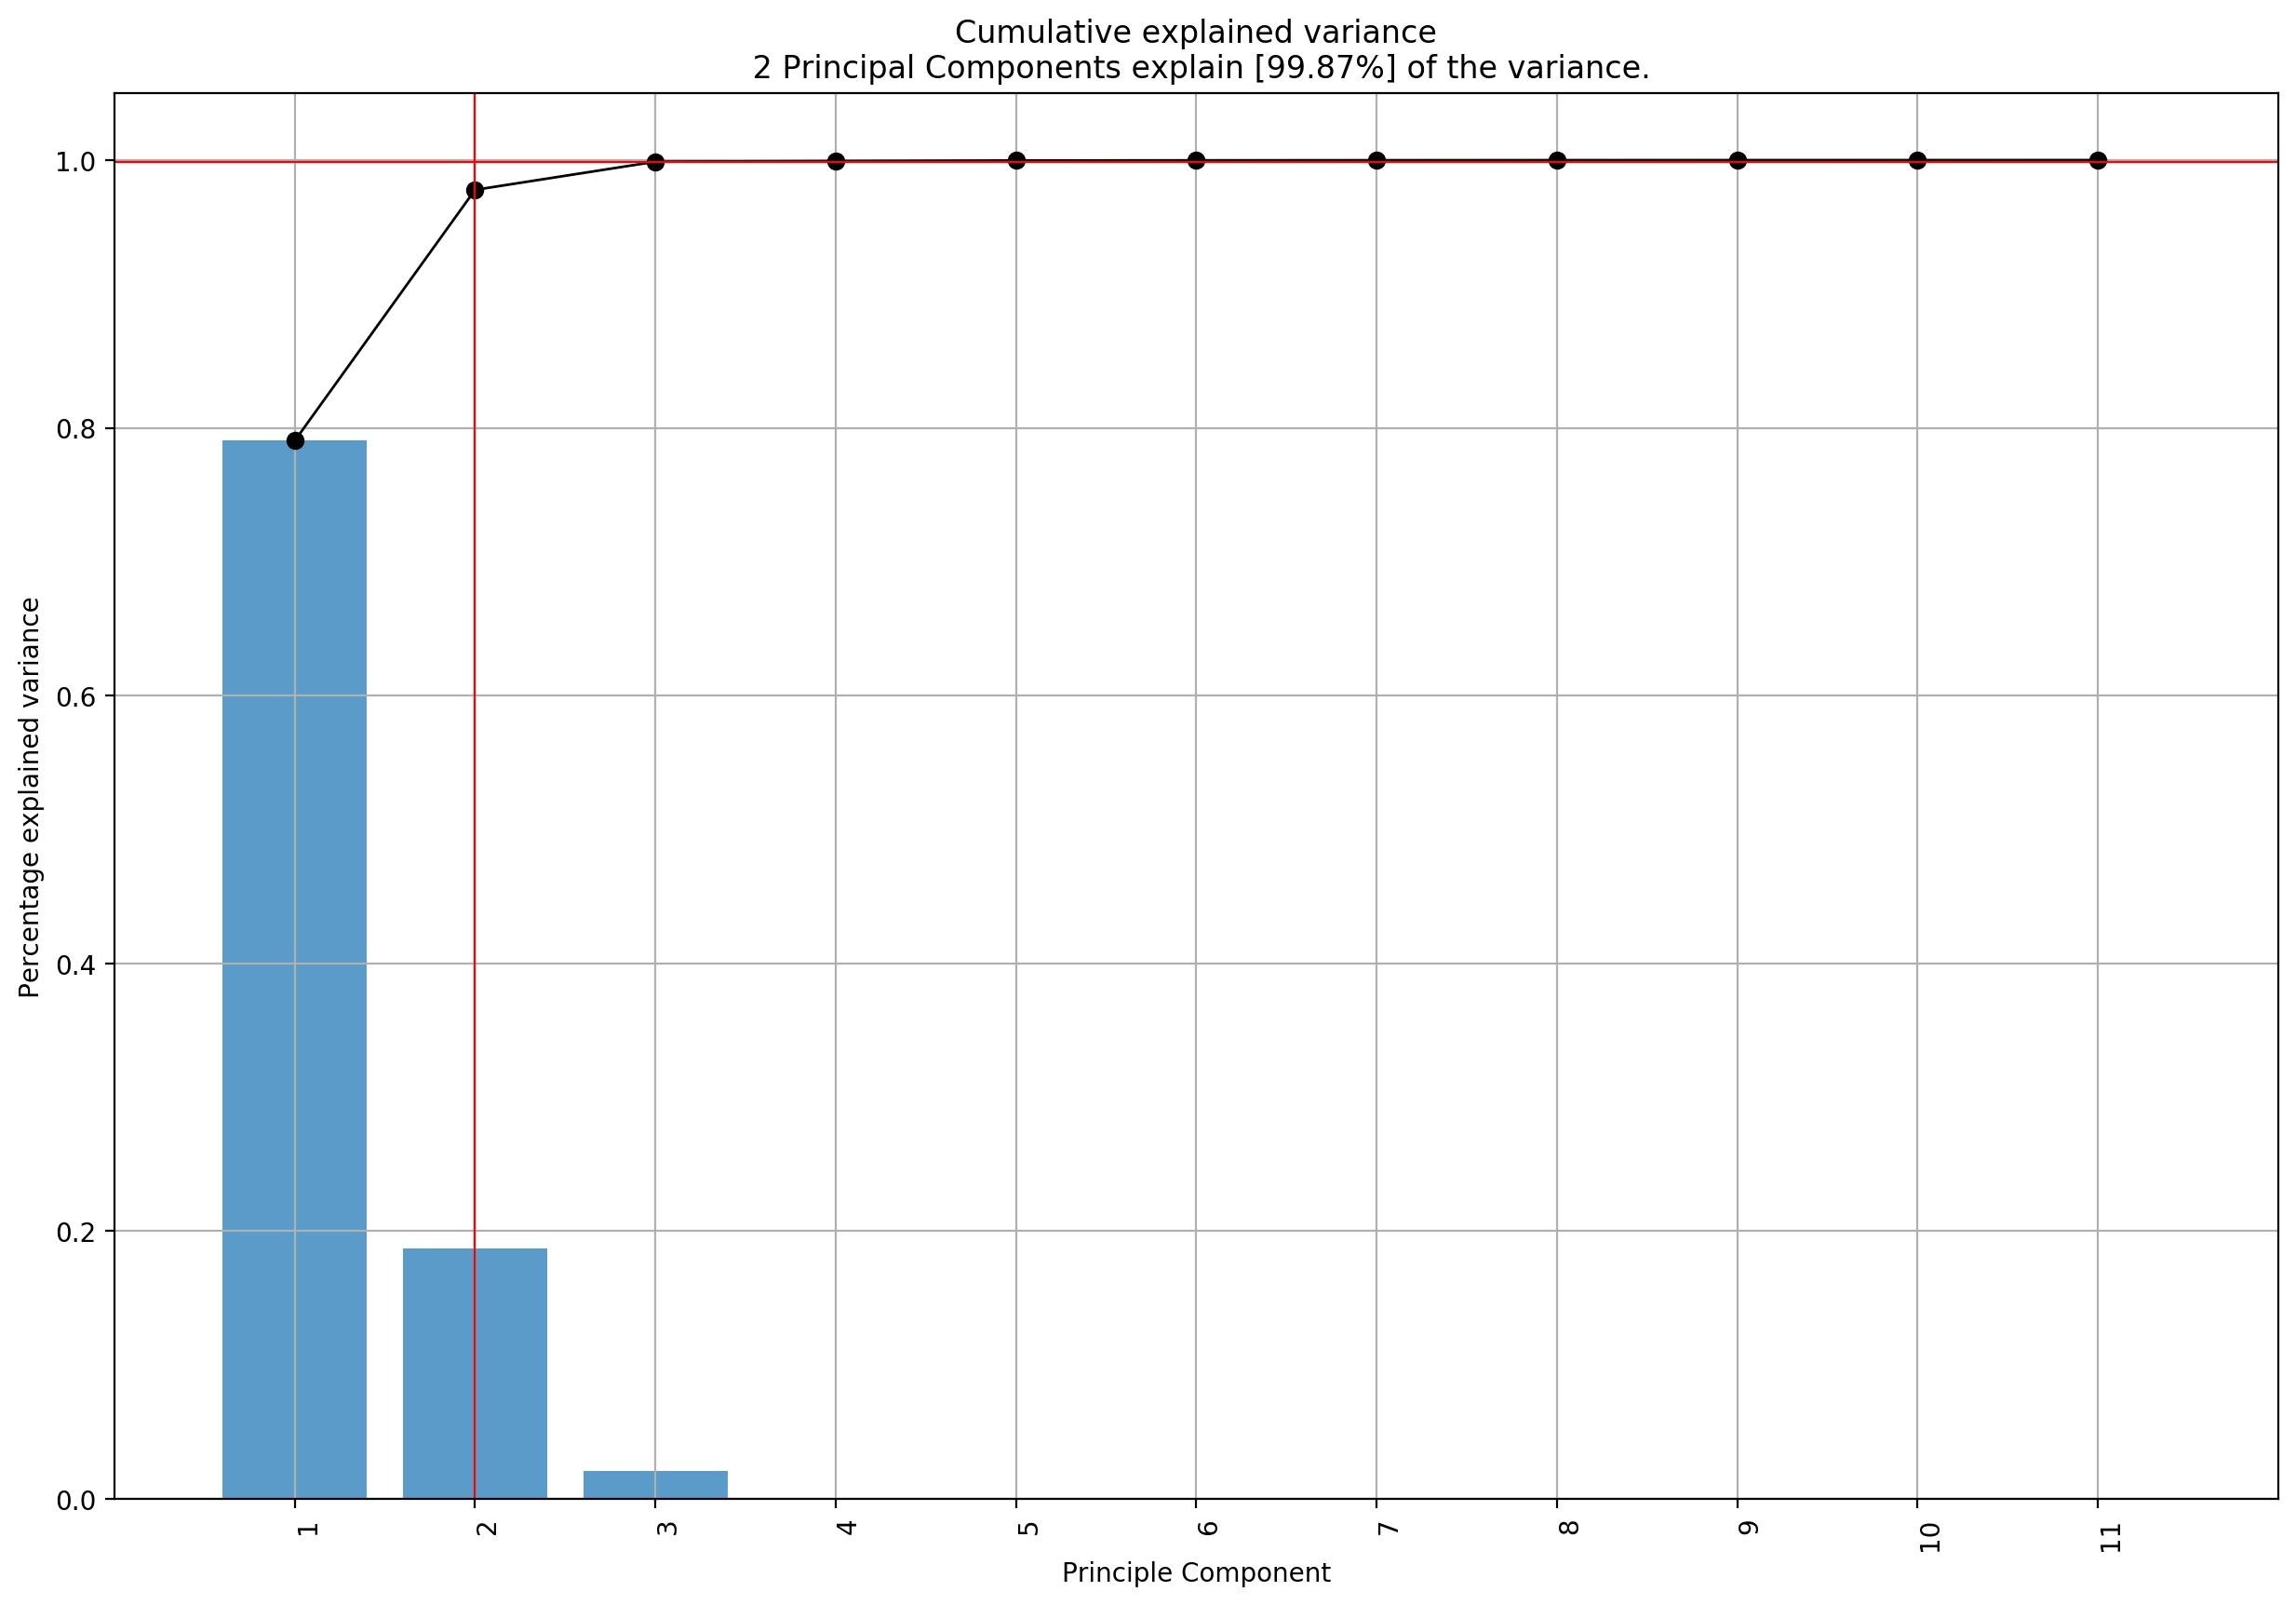

(<Figure size 3000x2000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f17162d2190>)

<Figure size 1000x1000 with 0 Axes>

In [229]:
model = pca.pca()
out = model.fit_transform(data)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])
model.plot()

### Predicting stroke using Logistic Regression

In [198]:
def parse_point(line: list) -> LabeledPoint:
    return LabeledPoint(line[10], line[0: 10])

In [199]:
data_spark = spark.createDataFrame(data).rdd.map(list)
data_spark = data_spark.map(parse_point)

# Build the model (train the model with parsedDatas)
model = LogisticRegressionWithLBFGS.train(data_spark)

label_pred = data_spark.map(lambda p: (p.label, model.predict(p.features)))
accuracy = label_pred.filter(lambda v: v[0] == v[1]).count() / float(data_spark.count())
print(f"Testing Accuracy: {accuracy}")

Testing Accuracy: 0.9559991851700957


**ROC Curve**

In [200]:
actual_y = label_pred.map(lambda x: x[0]).collect()
predicted_y = label_pred.map(lambda x: x[1]).collect()

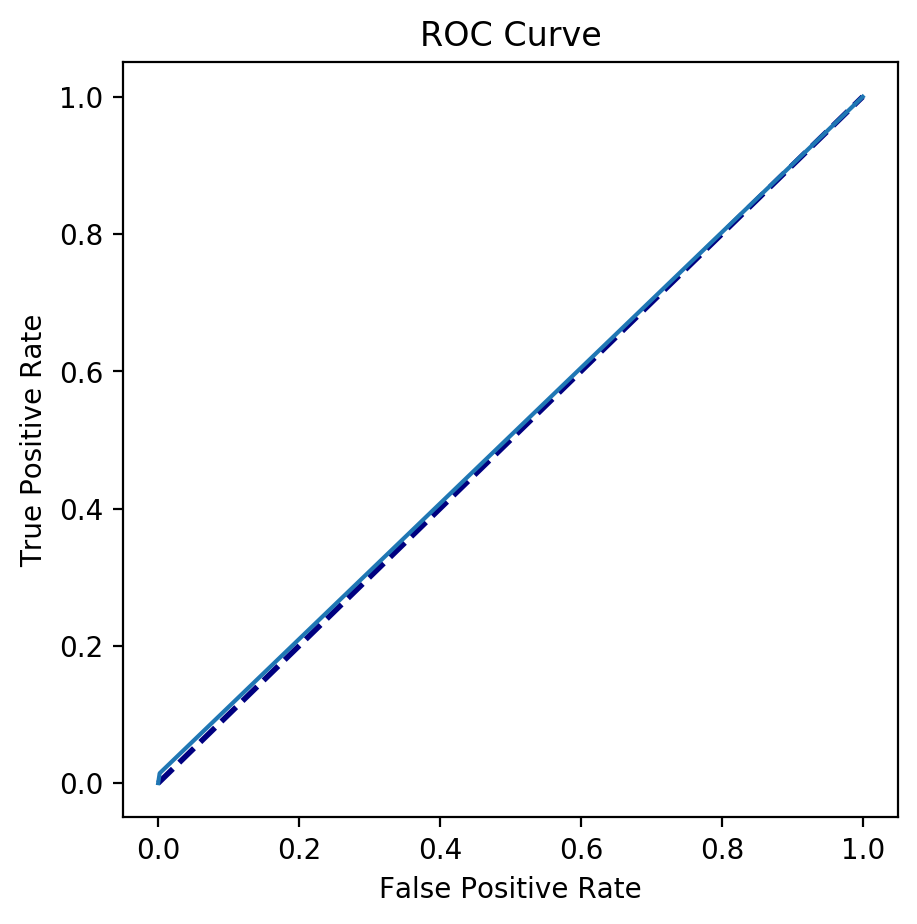

In [201]:
fpr, tpr, _ = roc_curve(actual_y, predicted_y)

# create ROC curve
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle="--")
plt.plot(fpr, tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

**Confusion Matrix**

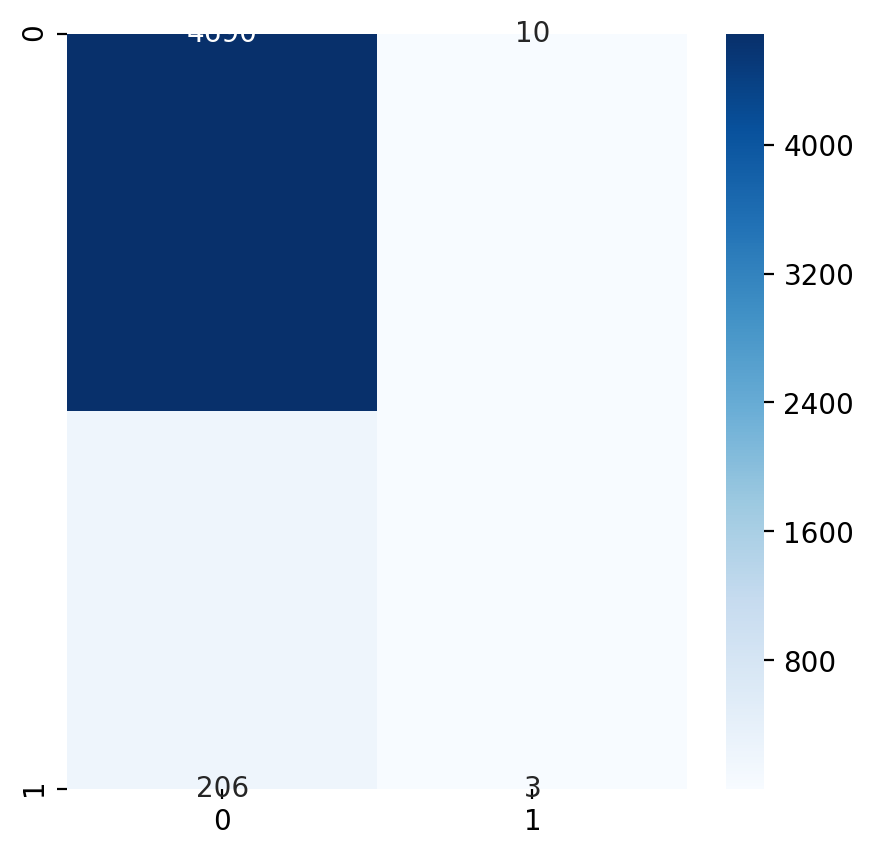

In [206]:
LR_confusion = confusion_matrix(actual_y, predicted_y)

ax = sns.heatmap(LR_confusion, annot = True, cmap = "Blues", fmt = "g")

plt.show()

### Predicting stroke using Random Forest Classifier

In [303]:
data_RF = spark.createDataFrame(data)

assembler = VectorAssembler(inputCols = feature_cols, 
                            outputCol = "features")

data_RF = assembler.transform(data_RF)
data_RF = data_RF.select(["features", "stroke"])

train_RF, test_RF = data_RF.randomSplit([0.8, 0.2])
print(f"Training Samples: {train_RF.count()}, Testing Samples: {test_RF.count()}")

Training Samples: 3955, Testing Samples: 954


**Creating Random forest classifier and training on data**

In [293]:
RF_classifier = RandomForestClassifier(labelCol = "stroke", numTrees = 60).fit(train_RF)
RF_predictions = RF_classifier.transform(test_RF)

In [294]:
RF_accuracy = BinaryClassificationEvaluator(labelCol = "stroke").evaluate(RF_predictions)
print(f"Random Forest Testing Accuracy: {RF_accuracy}")

Random Forest Testing Accuracy: 0.8128026634382566


**Plotting Feature Importance**

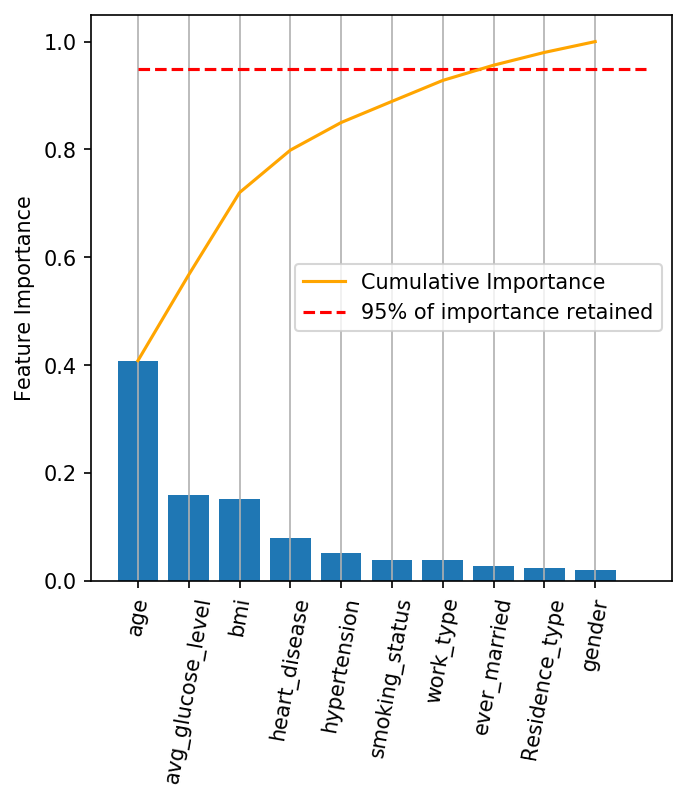

In [339]:
RF_importances = RF_classifier.featureImportances.toArray()
RF_importances = pd.Series(data = RF_importances, index = feature_cols, dtype = np.float64)
RF_importances = RF_importances.sort_values(ascending = False)

cumulative_importance = np.cumsum(RF_importances)

fig = plt.figure(dpi = 150, figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
cumulative_line = ax.plot(cumulative_importance.values, color = "orange", label = "Cumulative Importance")
importance_line = ax.bar(x = RF_importances.index, height = RF_importances.values)
# Draw line at 95% of importance retained
ax.hlines(y = 0.95, color = "r", linestyles = "dashed", xmin = 0, 
          xmax = len(feature_cols), label = "95% of importance retained")
plt.xticks(rotation = 80)
ax.grid(axis = "x")
ax.set_ylabel("Feature Importance")
ax.legend()